In [1]:
## which python is using
import sys
sys.executable

'/home/hcp4715/miniconda3/envs/py37/bin/python'

# <center>Using BIDS, Nipy, & related tools for fMRI data processing</center>

<center>Presented by Chuan-Peng Hu.</center>

<center>Post-doc @ Leibniz Institute for Resislience Research, Mainz, DE.</center>

## <center>Outline</center>

- Why we may benefit from using Nipy & tools

- BIDS, heudicov, and BIDSonym

- fmriprep: standardized preprocessing pipeline

- MRIQC: checking data quality

- Nipype: flexible and efficient workflow

## Toolboxs that are useful:
* Heudiconv (from Dicom -> BIDS)
* BIDSonym (de-identification of the MRI data)
* MRIQC (quality check of the MRI data)
* fMRIprep (standardized preprocessing)
* Nipype (flexible and simple workflow)

# 1. Why should we used them

* (Ir)reproducibility 
    
    * Flexibility in data processing

* <span style="color:gray">Easier (if we started with learning them)</span>

![Poldrack 2016](./files/Poldrack_2017_horizon.png "Varibility is huge!")

<div style="text-align: right"> <em>Poldrack et al., 2016, Nat. Rev. Neurosci., doi:10.1038/nrn.2016.167 </em> </div>

# 1. Why should we used them

* (Ir)reproducibility 
    
    * Flexibility in data processing

* <span style="color:gray">Easier (if we started with learning them)</span>

![Botvinik 2020](./files/Botvinik_etal_nature.png "Varibility is huge!")

<div style="text-align: right"> <em> Botvinik et al., 2020, Nature </em> </div>

Raw data --> Nifti --> Preprocess --> Quality check --> First level --> Second level --> ...
       
       Heudiconv      fmriprep    MRIQC          Nipype + other toolbox

In [2]:
!pip install graphviz

  Using cached graphviz-0.14-py2.py3-none-any.whl (18 kB)


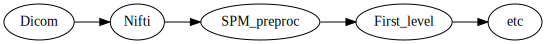

In [5]:
from graphviz import Source

src = Source('digraph "SPM_proc" { rankdir=LR; Dicom -> Nifti -> SPM_preproc -> First_level -> etc }')
src.render('files/SPM_proc.png', view=False)

Source.from_file('files/SPM_proc.png')
#def draw(dot):
#    return Image(pgv.AGraph(dot).draw(format='png', prog='dot'))

#g1 = """digraph top {
#   Rawdata -> Nifti -> Preproces;
#}"""
#draw(g1)

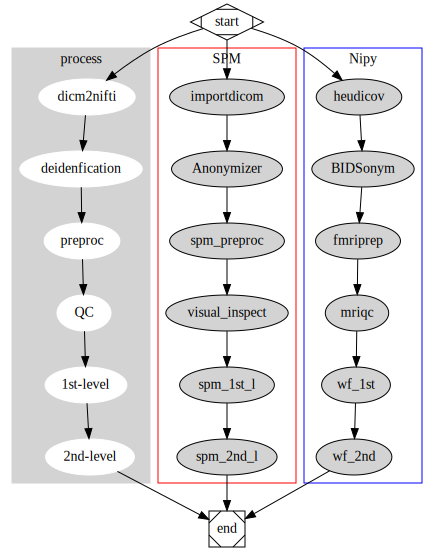

In [19]:
from graphviz import Digraph

g = Digraph('G', filename='cluster.gv')

# NOTE: the subgraph name needs to begin with 'cluster' (all lowercase)
#       so that Graphviz recognizes it as a special cluster subgraph

with g.subgraph(name='cluster_0') as c:
    c.attr(style='filled', color='lightgrey')
    c.node_attr.update(style='filled', color='white')
    c.edges([('dicm2nifti', 'deidenfication'), ('deidenfication', 'preproc'), ('preproc', 'QC'), ('QC', '1st-level'), ('1st-level', '2nd-level')])
    c.attr(label='process')

with g.subgraph(name='cluster_1') as c:
    c.attr(color='red')
    c.node_attr['style'] = 'filled'
    c.edges([('importdicom', 'Anonymizer'), ('Anonymizer', 'spm_preproc'), ('spm_preproc', 'visual_inspect'), ('visual_inspect', 'spm_1st_l'), ('spm_1st_l', 'spm_2nd_l')])
    c.attr(label='SPM')

with g.subgraph(name='cluster_2') as c:
    c.attr(color='blue')
    c.node_attr['style'] = 'filled'
    c.edges([('heudicov', 'BIDSonym'), ('BIDSonym', 'fmriprep'), ('fmriprep', 'mriqc'), ('mriqc', 'wf_1st'), ('wf_1st', 'wf_2nd')])
    c.attr(label='Nipy')
    
g.edge('start', 'dicm2nifti')
g.edge('start', 'importdicom')
g.edge('start', 'heudicov')
#g.edge('heudicov', 'docker')
#g.edge('BIDSonym', 'docker')
#g.edge('fmriprep', 'docker')
#g.edge('mriqc', 'docker')
#g.edge('wf_1st', 'Nipype')
#g.edge('wf_2nd', 'Nipype')
g.edge('2nd-level', 'end')
g.edge('spm_2nd_l', 'end')
g.edge('wf_2nd','end')

g.node('start', shape='Mdiamond')
g.node('end', shape='Msquare')

#g.view()

g.render('files/SPM_proc.png', view=False)

Source.from_file('files/SPM_proc.png')

## What's difference?

The difference is: 
    heudicov, BIDSonym, fmriprep, and mriqc can run as docker images, which means, we only need one line of code to run them:
   
```bash
sudo docker run -it --rm -v /home/user/Data/RepDopa/Nipy/BIDS:/data:ro \
-v /home/user/Data/RepDopa/Nipy/BIDS/derivatives/mriqc:/out \
-v /home/user/tmp:/tmp \
poldracklab/mriqc:latest /data /out \
participant \
--omp-nthreads 12 \
-w /tmp \
--verbose-reports
```